# Trigger Revision for 2025/2026 Cyclone Season

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
import ocha_stratus as stratus
import matplotlib.pyplot as plt
import geopandas as gpd
import math
from datetime import datetime, timedelta
from src.datasources import codab, rsmc, imerg, helpers
from src import db_utils
from src.constants import *
from src.utils import *

c:\Users\pauni\Desktop\Work\OCHA\GitHub\ds-aa-moz-cyclones\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
adm1 = stratus.codab.load_codab_from_fieldmaps(iso3, admin_level=1)

In [4]:
load_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "processed"
    / "moz"
    / "landfall_time_location_fixed_adm1_v7_updated.csv"
)
landfall_df = pd.read_csv(load_path)
date_cols = ["year", "month", "day"]
landfall_df[date_cols] = landfall_df[date_cols].astype(int)
landfall_df["landfall_date"] = pd.to_datetime(
    landfall_df[["year", "month", "day"]]
)
landfall_df.tail()

,ISO_TIME,SID,SEASON,NUMBER,BASIN,NAME,LAT,LON,WMO_WIND,DIST2LAND,REU_LAT,REU_LON,REU_WIND,year,month,day,date,actual_within_land,point_location,landfall_date
25,11/03/2023 17:30,2023061S22036,2023,15.0,SI,FREDDY,-17.816667,37.116667,1094.166667,2.500000,NaN,NaN,NaN,2023,3,11,11/03/2023,True,Landfall,2023-03-11
26,12/03/2024 05:00,2024071S20039,2024,15.0,SI,FILIPO,-21.333333,35.033333,NaN,7.666667,NaN,NaN,NaN,2024,3,12,12/03/2024,True,Landfall,2024-03-12
27,NaN,2024345S11062,2024,NaN,SI,CHIDO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,12,15,NaN,NaN,NaN,2024-12-15
28,NaN,2025010S14060,2025,NaN,SI,DIKELEDI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025,1,13,NaN,NaN,NaN,2025-01-13
29,NaN,2025068S15046,2025,NaN,SI,JUDE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025,3,10,NaN,NaN,NaN,2025-03-10


In [119]:
query = """
SELECT * 
FROM storms.ibtracs_tracks_geo
WHERE basin = 'SI'
"""
with stratus.get_engine(stage="prod").connect() as con:
    gdf_tracks = gpd.read_postgis(query, con, geom_col="geometry")

In [6]:
query = """
SELECT *
FROM storms.ibtracs_storms
"""
with stratus.get_engine(stage="prod").connect() as con:
    df_storms = pd.read_sql(query, con)

In [166]:
df_storms[df_storms["name"] == "FREDDY"]

,sid,atcf_id,number,season,name,genesis_basin,provisional,storm_id
289,2023036S12117,SH112023,8,2023,FREDDY,SI,False,freddy_si_2023
12194,2009034S16126,SH142009,9,2009,FREDDY,SI,False,freddy_si_2009


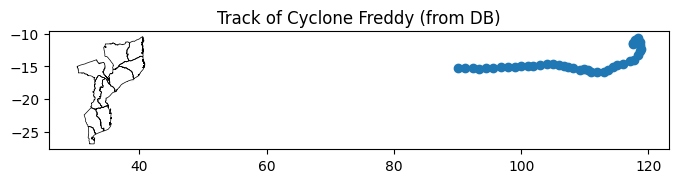

In [164]:
storm = gdf_tracks[gdf_tracks["sid"] == "2023036S12117"]

fig, ax = plt.subplots(figsize=(8, 6))
adm1.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=0.5)
storm.plot(ax=ax)

ax.set_title("Track of Cyclone Freddy (from DB)")
plt.show()

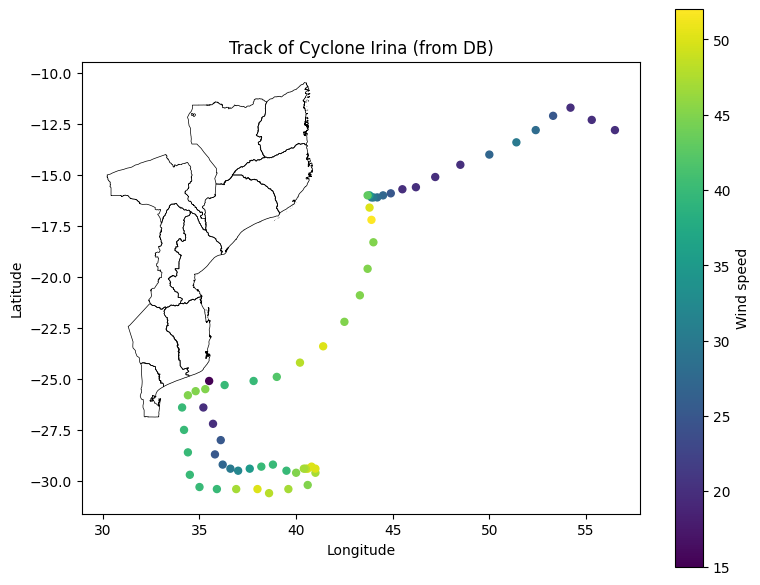

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

adm1.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=0.5)

storm = gdf_tracks[gdf_tracks["sid"] == "2012056S13057"].copy()
storm["wind_speed"] = pd.to_numeric(storm["wind_speed"], errors="coerce")

sc = ax.scatter(
    storm.geometry.x,
    storm.geometry.y,
    c=storm["wind_speed"],
    s=25,
)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Wind speed")

ax.set_title("Track of Cyclone Irina (from DB)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()

In [7]:
gdf_tracks = gdf_tracks.merge(df_storms)

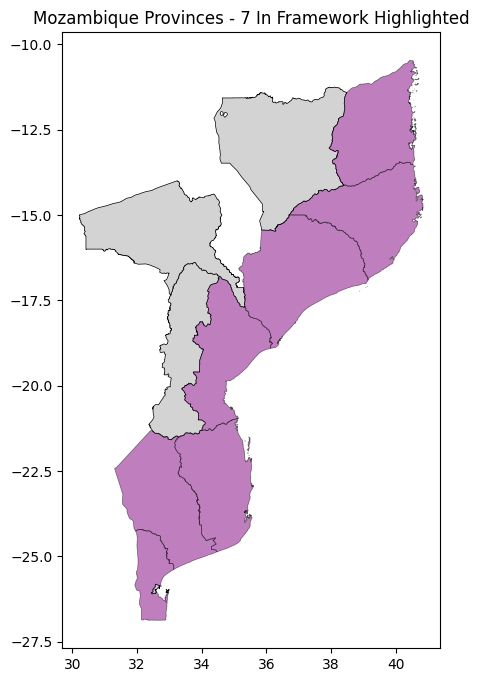

In [8]:
adm1["in_framework"] = adm1["adm1_name"].isin(ADMS)
fig, ax = plt.subplots(figsize=(10, 8))
adm1[adm1["in_framework"] == False].plot(
    ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5
)
adm1[adm1["in_framework"] == True].plot(
    ax=ax, color="purple", edgecolor="black", linewidth=0.5, alpha=0.5
)
ax.set_title("Mozambique Provinces - 7 In Framework Highlighted")
plt.show()

In [9]:
# to add the return period based on the revisions
# 7 provinces in the framework
# threshold of 118km/h (64 knots) for wind speed
# threshold of 120mm for rainfall over 3 days

# df_rsmc = rsmc.load_historical_forecast_distances()
# distance_cols = [x for x in df_rsmc.columns if "_distance_km" in x]
# df_rsmc["any_distance_km"] = df_rsmc[distance_cols].min(axis=1)

In [10]:
# intersecting df_rsmc with adm1 to get only the relevant provinces
df_rsmc = rsmc.load_processed_historical_forecasts()
# turn latitude and longitude into a geodataframe
df_rsmc = gpd.GeoDataFrame(
    df_rsmc,
    geometry=gpd.points_from_xy(df_rsmc["longitude"], df_rsmc["latitude"]),
    crs="OGC:CRS84",
)
df_rsmc_adm1 = gpd.sjoin(
    df_rsmc,
    adm1[adm1["in_framework"] == True],
    how="inner",
    predicate="within",
)
df_rsmc_adm1.head(5)

,cyclone_name,cyclone_number,basin,lt_hour,valid_time,latitude,longitude,min_presssure_hpa,last_isobar_pres_hpa,last_isobar_rad_nm,...,region2_nm,region1_cd,region1_nm,status_cd,status_nm,wld_date,wld_update,wld_view,wld_notes,in_framework
70,FREDDY,7,SWI,36,2023-03-11 18:00:00+00:00,-17.52,37.02,NaN,NaN,NaN,...,Sub-Saharan Africa,2,Africa,1,State,2025-02-24,2025-07-29,intl,None,True
71,FREDDY,7,SWI,48,2023-03-12 06:00:00+00:00,-17.34,36.58,NaN,NaN,NaN,...,Sub-Saharan Africa,2,Africa,1,State,2025-02-24,2025-07-29,intl,None,True
72,FREDDY,7,SWI,60,2023-03-12 18:00:00+00:00,-17.07,36.13,NaN,NaN,NaN,...,Sub-Saharan Africa,2,Africa,1,State,2025-02-24,2025-07-29,intl,None,True
73,FREDDY,7,SWI,72,2023-03-13 06:00:00+00:00,-16.80,35.48,NaN,NaN,NaN,...,Sub-Saharan Africa,2,Africa,1,State,2025-02-24,2025-07-29,intl,None,True
129,0620182019,6,SWI,84,2019-01-22 18:00:00+00:00,-18.56,35.08,NaN,NaN,NaN,...,Sub-Saharan Africa,2,Africa,1,State,2025-02-24,2025-07-29,intl,None,True


In [11]:
df_rsmc_adm1.columns

Index(['cyclone_name', 'cyclone_number', 'basin', 'lt_hour', 'valid_time',
       'latitude', 'longitude', 'min_presssure_hpa', 'last_isobar_pres_hpa',
       'last_isobar_rad_nm', 'max_wind_kt', 'max_wind_gusts_kt',
       'max_wind_radius_nm', 'nwq_27kt_nm', 'neq_27kt_nm', 'seq_27kt_nm',
       'swq_27kt_nm', 'nwq_34kt_nm', 'neq_34kt_nm', 'seq_34kt_nm',
       'swq_34kt_nm', 'nwq_50kt_nm', 'neq_50kt_nm', 'seq_50kt_nm',
       'swq_50kt_nm', 'issue_time', 'season', 'nwq_64kt_nm', 'neq_64kt_nm',
       'seq_64kt_nm', 'swq_64kt_nm', 'numberseason', 'geometry', 'index_right',
       'fid', 'adm1_id', 'adm1_src', 'adm1_name', 'adm1_name1', 'adm1_name2',
       'adm0_id', 'adm0_src', 'adm0_name', 'adm0_name1', 'adm0_name2',
       'src_lvl', 'src_lang', 'src_lang1', 'src_lang2', 'src_date',
       'src_update', 'src_name', 'src_name1', 'src_lic', 'src_url', 'src_grp',
       'iso_cd', 'iso_2', 'iso_3', 'iso_3_grp', 'region3_cd', 'region3_nm',
       'region2_cd', 'region2_nm', 'region1_cd'

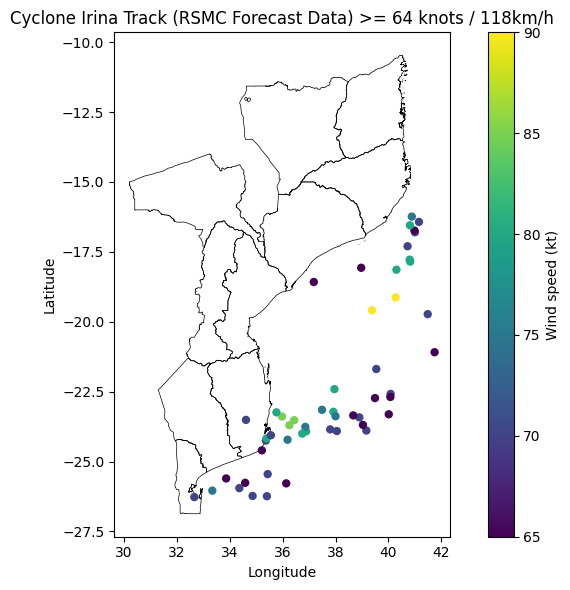

In [176]:
fig, ax = plt.subplots(figsize=(8, 6))

adm1.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=0.5)

irina = df_rsmc[df_rsmc["cyclone_name"].str.upper() == "IRINA"].copy()

irina["max_wind_kt"] = pd.to_numeric(irina["max_wind_kt"], errors="coerce")
irina64 = irina[irina["max_wind_kt"] >= 64]

sc = ax.scatter(
    irina64.geometry.x,
    irina64.geometry.y,
    c=irina64["max_wind_kt"],
    s=25,
)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Wind speed (kt)")

ax.set_title("Cyclone Irina Track (RSMC Forecast Data) >= 64 knots / 118km/h")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()

In [12]:
IMERG_START_DATE = pd.to_datetime("2000-06-01")
extra_days = 1
aoi_adm1_pcodes = adm1[adm1["in_framework"]]["adm1_src"].unique()
dfs = []
for sid, row in landfall_df.set_index("SID").iterrows():
    landfall_date = row["landfall_date"]
    start_date = landfall_date - pd.Timedelta(days=extra_days)
    end_date = landfall_date + pd.Timedelta(days=extra_days)
    if end_date < IMERG_START_DATE:
        print(f"{row['NAME']} too early")
        continue
    df_in = imerg.fetch_imerg_data(aoi_adm1_pcodes, start_date, end_date)
    df_in["SID"] = sid
    df_in["NAME"] = row["NAME"]
    dfs.append(df_in)
imerg_df = pd.concat(dfs, ignore_index=True)
imerg_sum_df = (
    imerg_df.groupby(["pcode", "SID", "NAME"])["mean"].sum().reset_index()
)
imerg_sum_df = imerg_sum_df.rename(columns={"mean": "sum_mean_rain"})
imerg_sum_df.head()

ASTRIDE too early
ELINE:LEONE too early
GLORIA too early
HUDAH too early


,pcode,SID,NAME,sum_mean_rain
0,MZ01,2002364S16045,DELFINA,0.016015
1,MZ01,2003056S21042,JAPHET,0.171965
2,MZ01,2007043S11071,FAVIO,12.483385
3,MZ01,2008062S10064,JOKWE,47.419393
4,MZ01,2009082S16039,IZILDA,16.721129


### Return Period

In [99]:
ibtracs_path = adm1_path = (
    Path(AA_DATA_DIR) / "public" / "raw" / "glb" / "ibtracs"
)
points_path = Path(
    ibtracs_path
    / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)
gdf_ibtracs = gpd.read_file(points_path)
# shifting to using the stratus loader

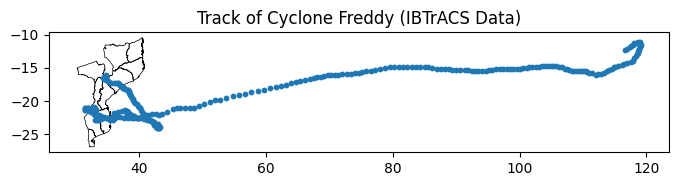

In [126]:
storm = gdf_ibtracs[
    (gdf_ibtracs["NAME"] == "FREDDY") & (gdf_ibtracs["year"] == 2023)
]

fig, ax = plt.subplots(figsize=(8, 6))
adm1.to_crs(gdf_ibtracs.crs).plot(
    ax=ax, edgecolor="black", facecolor="none", linewidth=0.5
)
storm.plot(ax=ax, markersize=10)

ax.set_title("Track of Cyclone Freddy (IBTrACS Data)")
plt.show()

In [14]:
def calculate_storm_return_period(
    df, wind_speed_kmh, start_year, num_storms_year
):
    """
    Calculates the return period for cyclones based on wind speed threshold.

    Args:
    df: DataFrame containing the cyclone data.
    wind_speed_kmh: Wind speed threshold in km/h.
    start_year: The year to start the calculation from.
    num_storms_year: Number of storms to predict per year.

    Returns:
    None (Prints the return period and probability).
    """
    # Conversion factor from kilometers per hour to knots
    kmh_to_knots = 1 / KPH2KNOTS

    # Convert the given speed from km/h to knots
    speed_knots = wind_speed_kmh * kmh_to_knots

    df["year"] = (
        df["valid_time"]
        .astype(str)
        .apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year)
    )

    # Filter the DataFrame for records from the start year and with wind speed above the threshold
    df_filtered = df[
        (df["year"] >= start_year) & (df["wind_speed"] >= speed_knots)
    ]

    # Count unique storms
    unique_storms = df_filtered["name"].nunique()

    # Calculate the total number of years in the filtered DataFrame
    yr_len = 2025 - start_year + 1

    # Calculate the combined return period
    combined_return_period = yr_len / unique_storms

    print(
        f"The combined return period of storms over {wind_speed_kmh}km/h is 1-in-{round(combined_return_period, 1)} years."
    )

    # http://hurricanepredictor.com/Methodology/USmethodology.pdf
    # Trying out the methodology above
    # using Poisson distribution
    ave_num = unique_storms / yr_len
    expected_probability = (
        math.exp(-ave_num)
        * (ave_num**num_storms_year)
        / math.factorial(num_storms_year)
    )
    print(
        f"Probability of {num_storms_year} or more storms occurring in any given year is {expected_probability:.4f}."
    )

In [92]:
adm1.to_crs(gdf_tracks.crs, inplace=True)
gdf_points_adm1 = gpd.sjoin(
    gdf_tracks, adm1, how="inner", predicate="intersects"
)
calculate_storm_return_period(gdf_points_adm1, THRESHOLD_SPEED_OPT2, 1980, 1)

The combined return period of storms over 118km/h is 1-in-3.3 years.
Probability of 1 or more storms occurring in any given year is 0.2245.


In [93]:
gdf_points_adm1[
    gdf_points_adm1["wind_speed"] >= (THRESHOLD_SPEED_OPT2 / KPH2KNOTS)
]["name"].unique()

array(['DIKELEDI', 'ANGELE', 'FILAO', 'ELINE:LEONE', 'HUDAH', 'JAPHET',
       'FAVIO', 'JOKWE', 'DINEO', 'IDAI', 'KENNETH', 'ELOISE', 'CHIDO',
       'JUDE', 'GOMBE'], dtype=object)

In [ ]:
# why is Freddy not in this list?
# because the data in the DB is incomplete for Freddy
gdf_points_adm1[gdf_points_adm1["name"] == "FREDDY"]

,wind_speed,pressure,max_wind_radius,last_closed_isobar_radius,last_closed_isobar_pressure,gust_speed,sid,provider,basin,nature,...,region1_cd,region1_nm,status_cd,status_nm,wld_date,wld_update,wld_view,wld_notes,in_framework,year


### Historical Validation

In [141]:
readiness_max_lt = 120
readiness_min_lt = 72
action_max_lt = 72
action_min_lt = 6
wind_speed_trigger_kmh = 118  # km/h
rainfall_trigger_mm = 170  # mm over 3 days, testing with 175mm
wind_speed_trigger_kts = 64  # knots

In [142]:
# getting last 8 digits to get seasons from column "numberseason"

num_seasons = (df_rsmc["numberseason"].astype(str).str[-8:]).nunique()
num_seasons

14

In [143]:
# checking the number of storms that would have triggered readiness
readiness_storms = df_rsmc_adm1[
    df_rsmc_adm1["lt_hour"].between(
        readiness_min_lt, readiness_max_lt, inclusive="both"
    )
    & (df_rsmc_adm1["max_wind_kt"] >= wind_speed_trigger_kts)
]["cyclone_name"].unique()
# adding recent storms
readiness_storms = list(readiness_storms) + ["CHIDO", "JUDE"]
readiness_storms

['IDAI',
 'IRINA',
 'GOMBE',
 '1420182019',
 'ELOISE',
 'FREDDY',
 'KENNETH',
 'CHIDO',
 'JUDE']

In [144]:
# readiness return period
num_seasons / len(readiness_storms)

1.5555555555555556

In [145]:
# checking the number of storms that would have triggered action
action_storms = df_rsmc_adm1[
    df_rsmc_adm1["lt_hour"].between(
        action_min_lt, action_max_lt, inclusive="both"
    )
    & (df_rsmc_adm1["max_wind_kt"] >= wind_speed_trigger_kts)
]["cyclone_name"].unique()
# adding chido, dikeledi and jude
action_storms = list(action_storms) + ["CHIDO", "DIKELEDI", "JUDE"]
action_storms

['IDAI',
 'GOMBE',
 'KENNETH',
 'ELOISE',
 'FREDDY',
 '1420182019',
 'IRINA',
 'DINEO',
 'CHIDO',
 'DIKELEDI',
 'JUDE']

In [146]:
# readiness return period
num_seasons / len(action_storms)

1.2727272727272727

In [147]:
obs_ws_storms = df_rsmc_adm1[
    df_rsmc_adm1["lt_hour"].between(0, action_min_lt, inclusive="both")
    & (df_rsmc_adm1["max_wind_kt"] >= wind_speed_trigger_kts)
]["cyclone_name"].unique()
obs_ws_storms = list(obs_ws_storms) + ["CHIDO", "DIKELEDI", "JUDE"]
obs_ws_storms

['IDAI', 'DINEO', 'GOMBE', 'KENNETH', 'FREDDY', 'CHIDO', 'DIKELEDI', 'JUDE']

In [148]:
# readiness return period
num_seasons / len(obs_ws_storms)

1.75

In [149]:
imerg_sum_df[imerg_sum_df["sum_mean_rain"] >= rainfall_trigger_mm]

,pcode,SID,NAME,sum_mean_rain
123,MZ07,2025010S14060,DIKELEDI,177.233882
124,MZ07,2025068S15046,JUDE,215.957052
137,MZ09,2019063S18038,IDAI,233.761901
167,MZ11,2022020S13059,ANA,172.006284
170,MZ11,2023061S22036,FREDDY,191.066692


In [157]:
# return period of rainfall storms
((2025 - IMERG_START_DATE.year) + 1) / (
    imerg_sum_df[imerg_sum_df["sum_mean_rain"] >= rainfall_trigger_mm][
        "NAME"
    ].nunique()
)

5.2

In [158]:
gdf_points_adm1 = gdf_points_adm1[gdf_points_adm1["year"] >= 1980]

In [ ]:
# wind speed return period
round(
    (2025 - 1980 + 1)
    / (
        gdf_points_adm1[
            (
                gdf_points_adm1["wind_speed"]
                >= (THRESHOLD_SPEED_OPT2 / KPH2KNOTS)
            )
            & (gdf_points_adm1["year"] >= 1980)
        ]["name"].nunique()
        + 1
    ),
    1,
)

3.1

In [160]:
pd.concat(
    [
        gdf_points_adm1.loc[
            (
                gdf_points_adm1["wind_speed"]
                >= (THRESHOLD_SPEED_OPT2 / KPH2KNOTS)
            ),
            "name",
        ],
        imerg_sum_df.loc[
            imerg_sum_df["sum_mean_rain"] >= rainfall_trigger_mm, "NAME"
        ],
    ],
    ignore_index=True,
)

0        DIKELEDI
1        DIKELEDI
2           FILAO
3     ELINE:LEONE
4     ELINE:LEONE
5           HUDAH
6          JAPHET
7           FAVIO
8           FAVIO
9           JOKWE
10          DINEO
11           IDAI
12        KENNETH
13         ELOISE
14          CHIDO
15           JUDE
16          GOMBE
17       DIKELEDI
18           JUDE
19           IDAI
20            ANA
21         FREDDY
dtype: object

In [ ]:
# combined return period
round(
    (2025 - 1980 + 1)
    / pd.concat(
        [
            gdf_points_adm1.loc[
                gdf_points_adm1["wind_speed"]
                >= (THRESHOLD_SPEED_OPT2 / KPH2KNOTS),
                "name",
            ],
            imerg_sum_df.loc[
                imerg_sum_df["sum_mean_rain"] >= rainfall_trigger_mm, "NAME"
            ],
        ],
        ignore_index=True,
    ).nunique(),
    1,
)

2.9

In [155]:
# Complete list of storms
storm_cerf_file = pd.read_csv(
    rsmc.DATA_DIR / "public" / "raw" / "moz" / "storms_cerf_data.csv"
)

In [156]:
# Lists of storm events
df = storm_cerf_file.copy()
df["Readiness"] = df["storm"].isin(readiness_storms)
df["Action"] = df["storm"].isin(action_storms)
df["Observational Wind Speed"] = df["storm"].isin(obs_ws_storms)
df["Observational Rainfall"] = df["storm"].isin(
    imerg_sum_df[imerg_sum_df["sum_mean_rain"] >= rainfall_trigger_mm]["NAME"]
)
df = df[
    [
        "storm",
        "Readiness",
        "Action",
        "Observational Wind Speed",
        "Observational Rainfall",
        "Total Affected",
        "CERF Allocations",
    ]
]

# Sort the DataFrame by 'Total Affected' in descending order
# Round values in 'Total Affected' and 'CERF Allocations' columns
df_sorted = df.sort_values(by="Total Affected", ascending=False)

# Apply styling
styled_df = (
    df_sorted.style.map(
        highlight_true,
        subset=[
            "Readiness",
            "Action",
            "Observational Wind Speed",
            "Observational Rainfall",
        ],
    )
    .map(lambda v: color_bar_affected(df_sorted, v), subset=["Total Affected"])
    .map(lambda v: color_bar_cerf(df_sorted, v), subset=["CERF Allocations"])
    .format(
        {
            "Total Affected": lambda x: (
                f"{int(x):,}" if pd.notna(x) else ""
            ),  # Format with commas, no decimals, NaN as blank
            "CERF Allocations": lambda x: (
                f"{int(x):,}" if pd.notna(x) else ""
            ),  # Format with commas, no decimals, NaN as blank
        }
    )
    .set_table_styles(
        {"": [{"selector": "table", "props": "background-color: white;"}]}
    )
)

styled_df

,storm,Readiness,Action,Observational Wind Speed,Observational Rainfall,Total Affected,CERF Allocations
12,IDAI,True,True,True,True,"1,628,167","14,018,121"
20,FREDDY,True,True,True,True,"1,230,691","9,995,213"
10,DINEO,False,True,True,False,"750,102","2,000,095"
18,GOMBE,True,True,True,False,"736,015","4,018,682"
15,ELOISE,True,True,False,False,"481,901",
22,CHIDO,True,True,True,False,"453,971","3,999,970"
13,KENNETH,True,True,True,False,"400,094","9,964,907"
24,JUDE,True,True,True,True,"385,000","6,053,738"
23,DIKELEDI,False,True,True,True,"283,334",
1,JOKWE,False,False,False,False,"220,013","548,913"
